In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

In [2]:
import warnings
# suppress warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import statsmodels.stats.api as sms

import src.utils.setup_figures as figures
import src.utils.basic as utils

In [3]:
from config import dir_config, main_config

base_data_dir = Path(dir_config.data.base)
raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)

data = pd.read_csv(Path(processed_dir, "processed_data60accu_allowed.csv"), index_col=None)
processed_metadata = pd.read_csv(Path(processed_dir, "processed_metadata_60accu_allowed.csv"), index_col=None)

# # exclude the following subjects where categorization score is more than 3
# reject_subs = processed_metadata.loc[processed_metadata["categorization_score"] > 3]['subject_id']
# processed_metadata = processed_metadata.loc[~processed_metadata["subject_id"].isin(reject_subs)]


In [4]:
processed_metadata['subject_id'].unique()

array(['P1', 'P4', 'P6', 'P7', 'P9', 'P11', 'P12', 'P13', 'P16', 'P17',
       'P18', 'P19', 'P20', 'P22', 'P23', 'P24', 'CG', 'COH', 'MBY', 'DP',
       'FUR', 'LBR', 'MAR', 'SMI', 'PAM', 'RW', 'SGA', 'BBK', 'BER',
       'RBA', 'RDE'], dtype=object)

In [5]:
data['subject'].unique()

array(['CG', 'COH', 'LHO', 'MBY', 'P1', 'P22', 'P23', 'P24', 'PAM', 'RBA',
       'RDE', 'RW', 'SGA', 'ALE', 'BBK', 'BER', 'DP', 'FUR', 'LBR', 'MAR',
       'P10', 'P11', 'P12', 'P13', 'P16', 'P17', 'P18', 'P19', 'P20',
       'P3', 'P4', 'P6', 'P7', 'P9', 'SMI'], dtype=object)

In [6]:
# Getting indices of on and off treatment from same subject in processed metadata
subject_treatment_idx = pd.DataFrame(columns=['subject', 'off', 'on'])
subtype_idx = pd.DataFrame(columns=['subject', 'off', 'on'])

for idx, sub in enumerate(processed_metadata['subject_id'].unique()):
    sub_df = processed_metadata.loc[processed_metadata['subject_id'] == sub]
    subject_treatment_idx.loc[idx] = [sub, sub_df.loc[sub_df['treatment'] == 'OFF'].index[0], sub_df.loc[sub_df['treatment'] == 'ON'].index[0]]

    # print(f"Subject {sub} with {sub_df['subject_id'].values}")
    print(f"Subject {sub} has {sub_df['categorization_score'].values} categorization_score")
    if np.sum(np.isnan(sub_df['categorization_score'])) == 0:
        # put off treatment first column and on treatment second column one row at a time
        subtype_idx.loc[idx] = [sub, sub_df.loc[sub_df['treatment'] == 'OFF'].index[0], sub_df.loc[sub_df['treatment'] == 'ON'].index[0]]
        
    # break

Subject P1 has [0.21590909 0.21590909] categorization_score
Subject P4 has [0.76363636 0.76363636] categorization_score
Subject P6 has [1.19318182 1.19318182] categorization_score
Subject P7 has [2.54545455 2.54545455] categorization_score
Subject P9 has [0.72727273 0.72727273] categorization_score
Subject P11 has [1.61538462 1.61538462] categorization_score
Subject P12 has [3.88888889 3.88888889] categorization_score
Subject P13 has [0.52066116 0.52066116] categorization_score
Subject P16 has [21. 21.] categorization_score
Subject P17 has [1.32167832 1.32167832] categorization_score
Subject P18 has [1.04132231 1.04132231] categorization_score
Subject P19 has [1.34343434 1.34343434] categorization_score
Subject P20 has [0.43108504 0.43108504] categorization_score
Subject P22 has [0.10606061 0.10606061] categorization_score
Subject P23 has [0.16600791 0.16600791] categorization_score
Subject P24 has [1.14545455 1.14545455] categorization_score
Subject CG has [nan nan] categorization_sco

In [7]:
subtype_idx

,subject,off,on
0,P1,0,1
1,P4,2,3
2,P6,4,5
3,P7,6,7
4,P9,9,8
5,P11,11,10
6,P12,13,12
7,P13,14,15
8,P16,17,16
9,P17,18,19


In [8]:
original_all_subjects = ['CG', 'COH', 'MBY', 'DP', 'FUR', 'LBR', 'MAR', 'SMI', 'RW', 'SGA']
original_trem_subjects = ['DP', 'FUR', 'LBR', 'MAR', 'SMI']
original_brady_subjects = ['CG', 'COH', 'MBY', 'RW', 'SGA']

new_trem_subjects = processed_metadata.loc[processed_metadata['categorization'] == 'tremor_dominant']['subject_id'].unique()
new_brady_subjects = processed_metadata.loc[processed_metadata['categorization'] == 'bradykinesia_dominant']['subject_id'].unique()
print(f"New tremor_subjects: {len(new_trem_subjects)} \t {new_trem_subjects}")
print(f"New brady_subjects: {len(new_brady_subjects)} \t{new_brady_subjects}")


new_all_subjects = subject_treatment_idx['subject'].unique()
new_subtype_subjects = subtype_idx['subject'].unique()
# print(f"New all_subjects: {new_all_subjects}")
# print(f"New subtype_subjects: {new_subtype_subjects}")

New tremor_subjects: 9 	 ['P6' 'P7' 'P11' 'P12' 'P16' 'P17' 'P18' 'P19' 'P24']
New brady_subjects: 7 	['P1' 'P4' 'P9' 'P13' 'P20' 'P22' 'P23']


### Psychometric Function plots

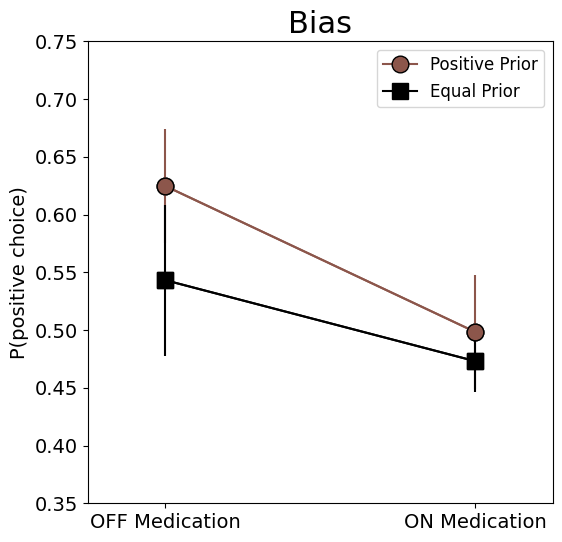

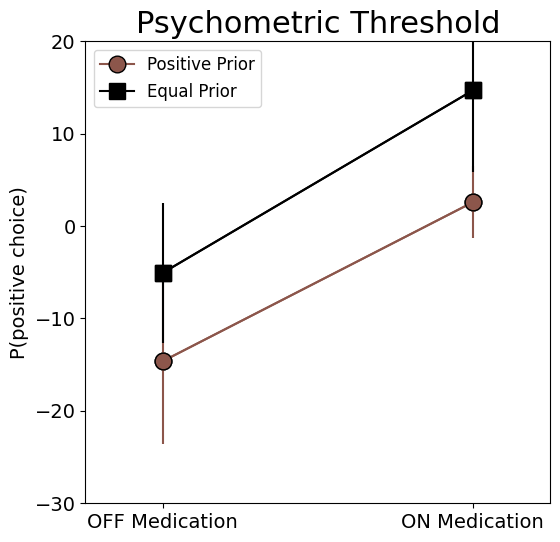

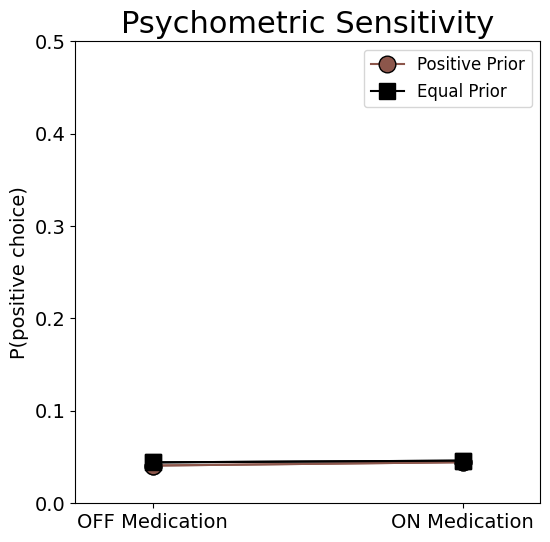

In [9]:
# subjects = new_trem_subjects
subjects = new_brady_subjects


positive_color = 'C5'
equal_color = 'black'
error_plot_style = {'elinewidth': 2, 'capsize': 10, 'capthick': 2}

subject_treatment_idx = pd.DataFrame(columns=['subject', 'off', 'on'])
for idx, sub in enumerate(subjects):
    sub_df = processed_metadata.loc[processed_metadata['subject_id'] == sub]
    subject_treatment_idx.loc[idx] = [sub, sub_df.loc[sub_df['treatment'] == 'OFF'].index[0], sub_df.loc[sub_df['treatment'] == 'ON'].index[0]]

independent_variable = ['bias', 'psych_alpha', 'psych_beta']
iv_idx = 2

# Bias Plots
for iv_idx in range(3):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    # get 
    OFF_positive_bias = processed_metadata.loc[subject_treatment_idx['off']][f'positive_{independent_variable[iv_idx]}']
    OFF_equal_bias = processed_metadata.loc[subject_treatment_idx['off']][f'equal_{independent_variable[iv_idx]}']
    ON_positive_bias = processed_metadata.loc[subject_treatment_idx['on']][f'positive_{independent_variable[iv_idx]}']
    ON_equal_bias = processed_metadata.loc[subject_treatment_idx['on']][f'equal_{independent_variable[iv_idx]}']

    plt.plot([0, 1], [np.mean(OFF_positive_bias), np.mean(ON_positive_bias)], color=positive_color, ls='-', marker='o', ms=12, mec='k', label='Positive Prior', alpha=1)
    plt.errorbar([0, 1], [np.mean(OFF_positive_bias), np.mean(ON_positive_bias)], yerr=[stats.sem(OFF_positive_bias), stats.sem(ON_positive_bias)], color=positive_color, ls='-', marker='o', ms=12, mec='k', alpha=1)
    plt.plot([0, 1], [np.mean(OFF_equal_bias), np.mean(ON_equal_bias)], color=equal_color, ls='-', marker='s', ms=12, mec='k', label='Equal Prior', alpha=1)
    plt.errorbar([0, 1], [np.mean(OFF_equal_bias), np.mean(ON_equal_bias)], yerr=[stats.sem(OFF_equal_bias), stats.sem(ON_equal_bias)], color=equal_color, ls='-', marker='s', ms=12, mec='k', alpha=1)
    plt.xticks([0, 1], ['OFF Medication', 'ON Medication'], fontsize=20)
    plt.tick_params(axis='both', labelsize=14)
    plt.ylabel('P(positive choice)', fontsize=14)
    plt.xlim(-0.25, 1.25)

    if iv_idx == 0:
        plt.ylim(0.35, 0.75)
        plt.title('Bias', fontsize=22)
    elif iv_idx == 1:
        plt.ylim(-30, 20)
        plt.title('Psychometric Threshold', fontsize=22)
    elif iv_idx == 2:
        plt.ylim(0, 0.5)
        plt.title('Psychometric Sensitivity', fontsize=22)
    plt.legend(fontsize=12)



In [10]:
# subjects1 = new_brady_subjects
# subjects2 = new_trem_subjects

# # join subjects1 and subjects2
# subjects = np.concatenate([subjects1, subjects2])
# subjects

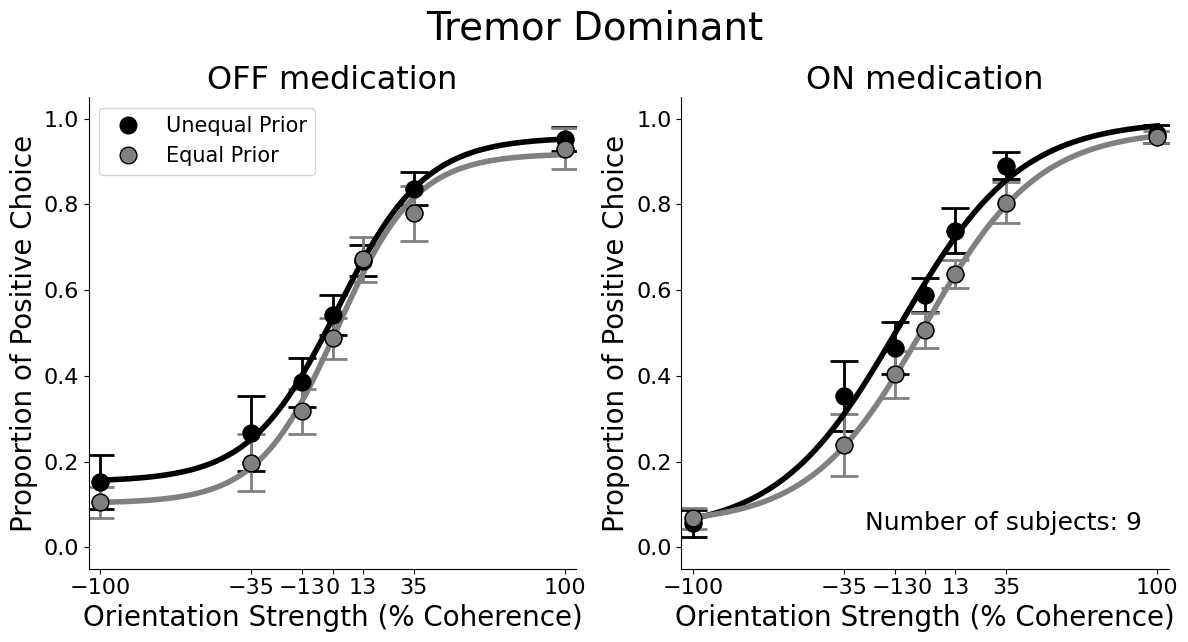

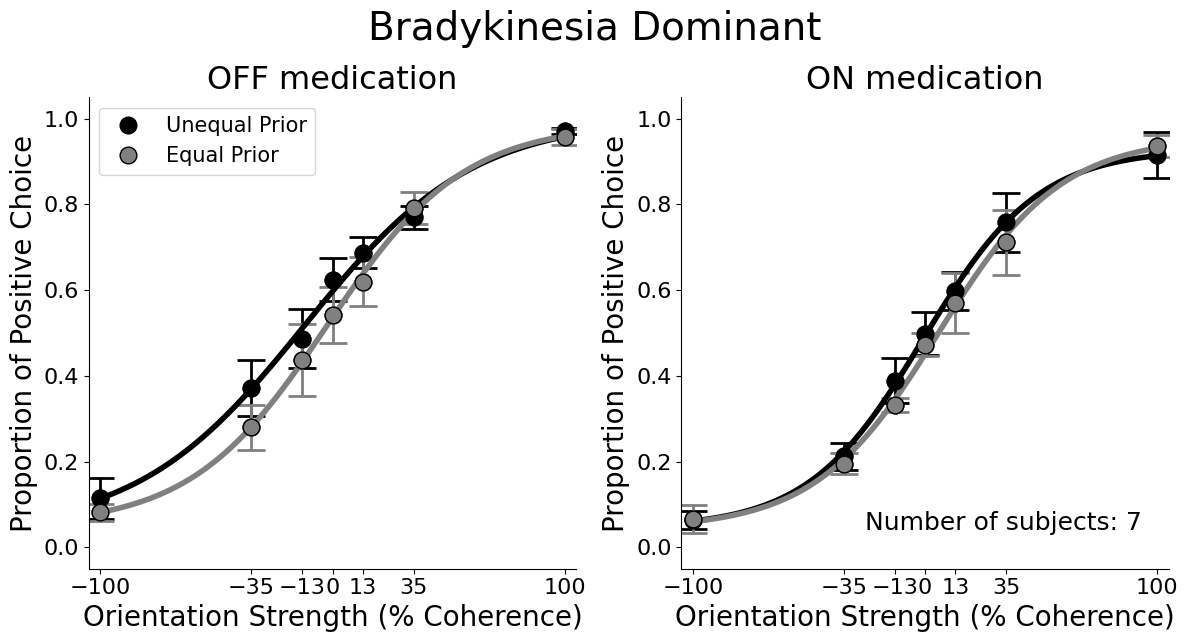

In [11]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors

# for category in ['all']:#, 'tremor_dominant', 'bradykinesia_dominant']:
for category in ['tremor_dominant', 'bradykinesia_dominant']:
    
    if category == 'all':
        subjects = np.concatenate([new_brady_subjects, new_trem_subjects, original_all_subjects])
        subtitle = 'PD Patients'
    elif category == 'tremor_dominant':
        subjects = new_trem_subjects
        subtitle = 'Tremor Dominant'
    elif category == 'bradykinesia_dominant':
        subjects = new_brady_subjects
        subtitle = 'Bradykinesia Dominant'

    fig, ax = plt.subplots(1, 2, figsize=(12, 6.5))
    subject_alpha = 0.08
    positive_color = 'black'# 'C5'
    equal_color = 'gray'
    error_plot_style = {'elinewidth': 2, 'capsize': 10, 'capthick': 2}

    sub_off_pos_coh, sub_off_pos_psych, sub_off_pos_model, sub_off_pos_x_hat, sub_off_pos_y_hat = [], [], [], [], []
    sub_off_eq_coh, sub_off_eq_psych, sub_off_eq_model, sub_off_eq_x_hat, sub_off_eq_y_hat = [], [], [], [], []
    sub_on_pos_coh, sub_on_pos_psych, sub_on_pos_model, sub_on_pos_x_hat, sub_on_pos_y_hat = [], [], [], [], []
    sub_on_eq_coh, sub_on_eq_psych, sub_on_eq_model, sub_on_eq_x_hat, sub_on_eq_y_hat = [], [], [], [], []

    for i, subject in enumerate(subjects):
        subject_data = data[data['subject'] == subject]
        subject_data = subject_data.sort_values('medication')
        
        for idx, med in enumerate(subject_data['medication'].unique()):
            med_data = subject_data[subject_data['medication'] == med]
            pos_coh, pos_psych, pos_model, pos_x_hat, pos_y_hat = utils.get_psychometric_data(med_data[med_data['color'] == 1])
            eq_coh, eq_psych, eq_model, eq_x_hat, eq_y_hat  = utils.get_psychometric_data(med_data[med_data['color'] == -1])

            if med == 'off':            
                ax_idx = 0
                sub_off_pos_coh.append(pos_coh)
                sub_off_pos_psych.append(pos_psych)
                sub_off_pos_model.append(pos_model)
                sub_off_pos_x_hat.append(pos_x_hat)
                sub_off_pos_y_hat.append(pos_y_hat)            
                sub_off_eq_coh.append(eq_coh)
                sub_off_eq_psych.append(eq_psych)
                sub_off_eq_model.append(eq_model)
                sub_off_eq_x_hat.append(eq_x_hat)
                sub_off_eq_y_hat.append(eq_y_hat)
            elif med == 'on':            
                ax_idx = 1
                sub_on_pos_coh.append(pos_coh)
                sub_on_pos_psych.append(pos_psych)
                sub_on_pos_model.append(pos_model)
                sub_on_pos_x_hat.append(pos_x_hat)
                sub_on_pos_y_hat.append(pos_y_hat)
                sub_on_eq_coh.append(eq_coh)
                sub_on_eq_psych.append(eq_psych)
                sub_on_eq_model.append(eq_model)
                sub_on_eq_x_hat.append(eq_x_hat)
                sub_on_eq_y_hat.append(eq_y_hat)
            
            # ax[ax_idx].plot(pos_coh, pos_psych, color=positive_color, ls='', alpha=subject_alpha)
            # ax[ax_idx].plot(pos_x_hat, pos_y_hat, color=positive_color, ls='-', alpha=subject_alpha)
            # ax[ax_idx].plot(eq_coh, eq_psych, color=equal_color, ls='', alpha=subject_alpha)
            # ax[ax_idx].plot(eq_x_hat, eq_y_hat, color=equal_color, ls='-', alpha=subject_alpha)


    ax[0].plot(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', label='Unequal Prior', alpha=1)
    ax[0].plot(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
    ax[0].errorbar(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), yerr=stats.sem(sub_off_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    ax[0].errorbar(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), yerr=stats.sem(sub_off_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    pos_model = utils.fit_psychometric_function(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0))
    eq_model = utils.fit_psychometric_function(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0))
    ax[0].plot(np.mean(sub_off_pos_x_hat, axis=0), pos_model.predict(np.mean(sub_off_pos_x_hat, axis=0)), color=positive_color, ls='-', lw=4, alpha=1)
    ax[0].plot(np.mean(sub_off_eq_x_hat, axis=0), eq_model.predict(np.mean(sub_off_eq_x_hat, axis=0)), color=equal_color, ls='-', lw=4, alpha=1)
    
    
    ax[1].plot(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', label='Unequal Prior', alpha=1)
    ax[1].plot(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
    ax[1].errorbar(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), yerr=stats.sem(sub_on_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    ax[1].errorbar(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), yerr=stats.sem(sub_on_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    pos_model = utils.fit_psychometric_function(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0))
    eq_model = utils.fit_psychometric_function(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0))
    ax[1].plot(np.mean(sub_on_pos_x_hat, axis=0), pos_model.predict(np.mean(sub_on_pos_x_hat, axis=0)), color=positive_color, ls='-', lw=4, alpha=1)
    ax[1].plot(np.mean(sub_on_eq_x_hat, axis=0), eq_model.predict(np.mean(sub_on_eq_x_hat, axis=0)), color=equal_color, ls='-', lw=4, alpha=1)
    
    
    ax[0].set_title(f"OFF medication", fontsize=23)
    ax[1].set_title(f"ON medication", fontsize=23)
    
    ax[0].legend(fontsize=15)
    
    for i in range(2):
        ax[i].set_xlabel('Orientation Strength (% Coherence)', fontsize=20)
        ax[i].set_ylabel('Proportion of Positive Choice', fontsize=20)
        ax[i].set_xlim(-105, 105)
        ax[i].set_ylim(-0.05, 1.05)
        ax[i].set_xticks([-100, -35, -13, 0, 13, 35, 100])
        ax[i].tick_params(axis='both', labelsize=16)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].grid(False)
    
    fig.suptitle(f"{subtitle}", fontsize=28)
    
    # Add a text annotation with the number of subjects
    fig.text(0.84, 0.18, f"Number of subjects: {len(subjects)}", ha='center', fontsize=18)
    # fig.text(0.35, 0.18, f"Number of subjects: {len(subjects)}", ha='center', fontsize=18)
    
    fig.tight_layout()
    plt.show()



### Perform analysis on bias, alpha, beta, gamma and delta based on categorization_score

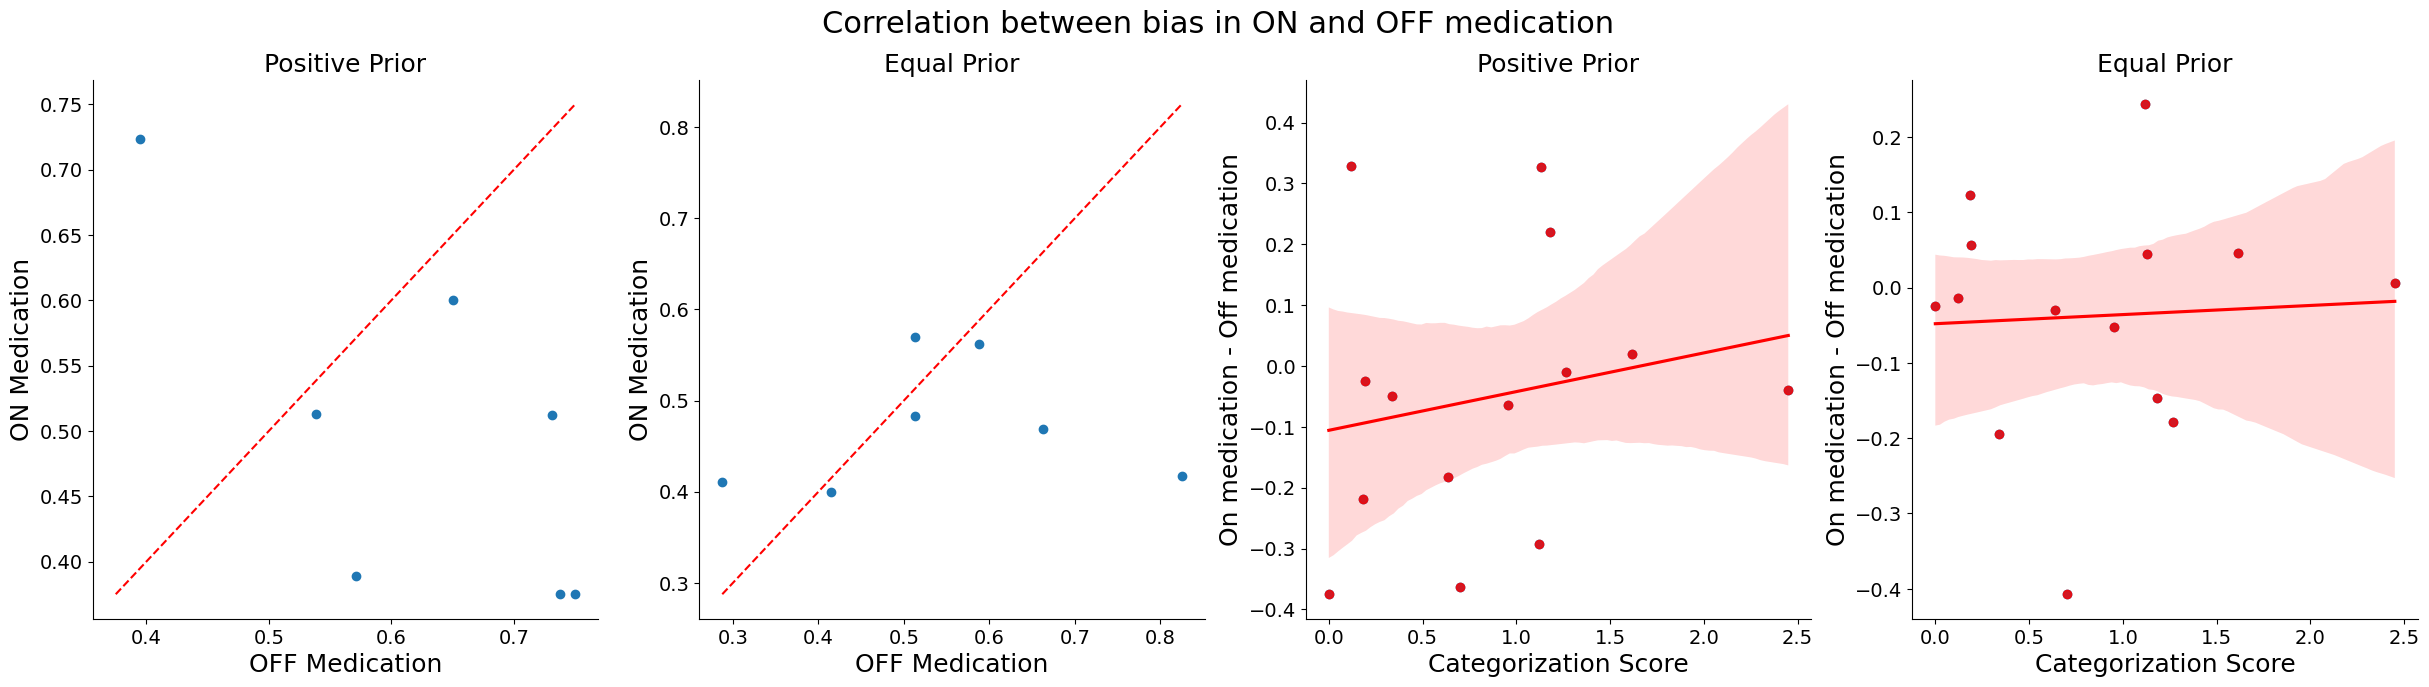

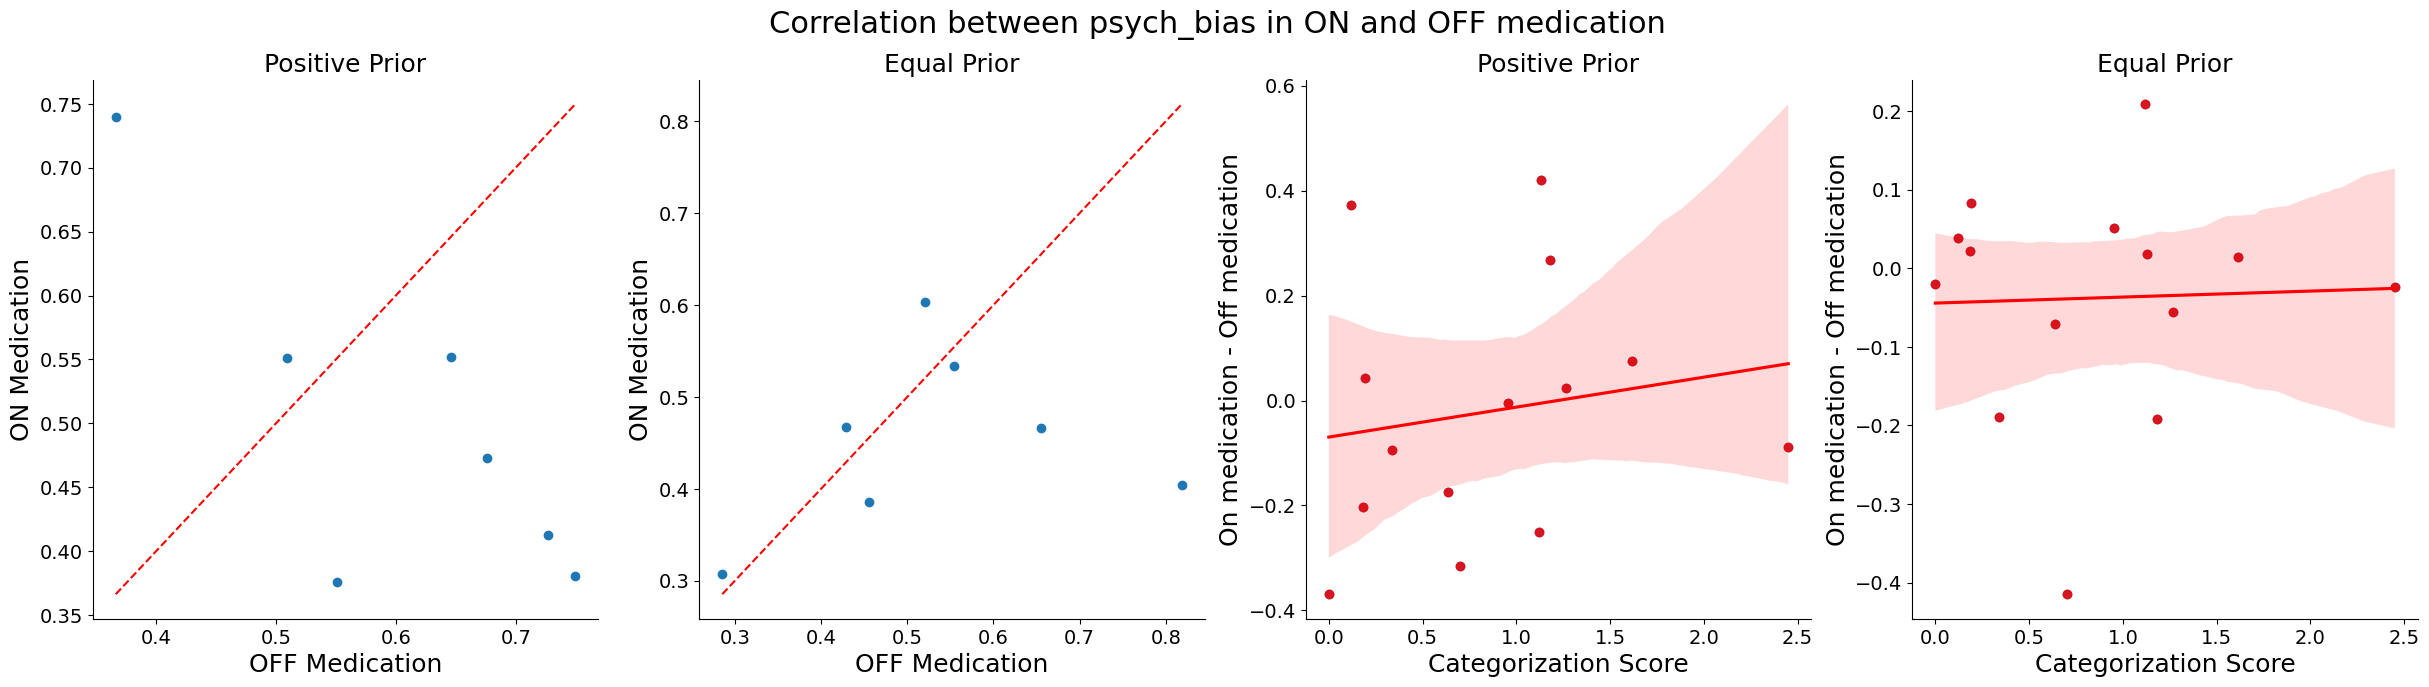

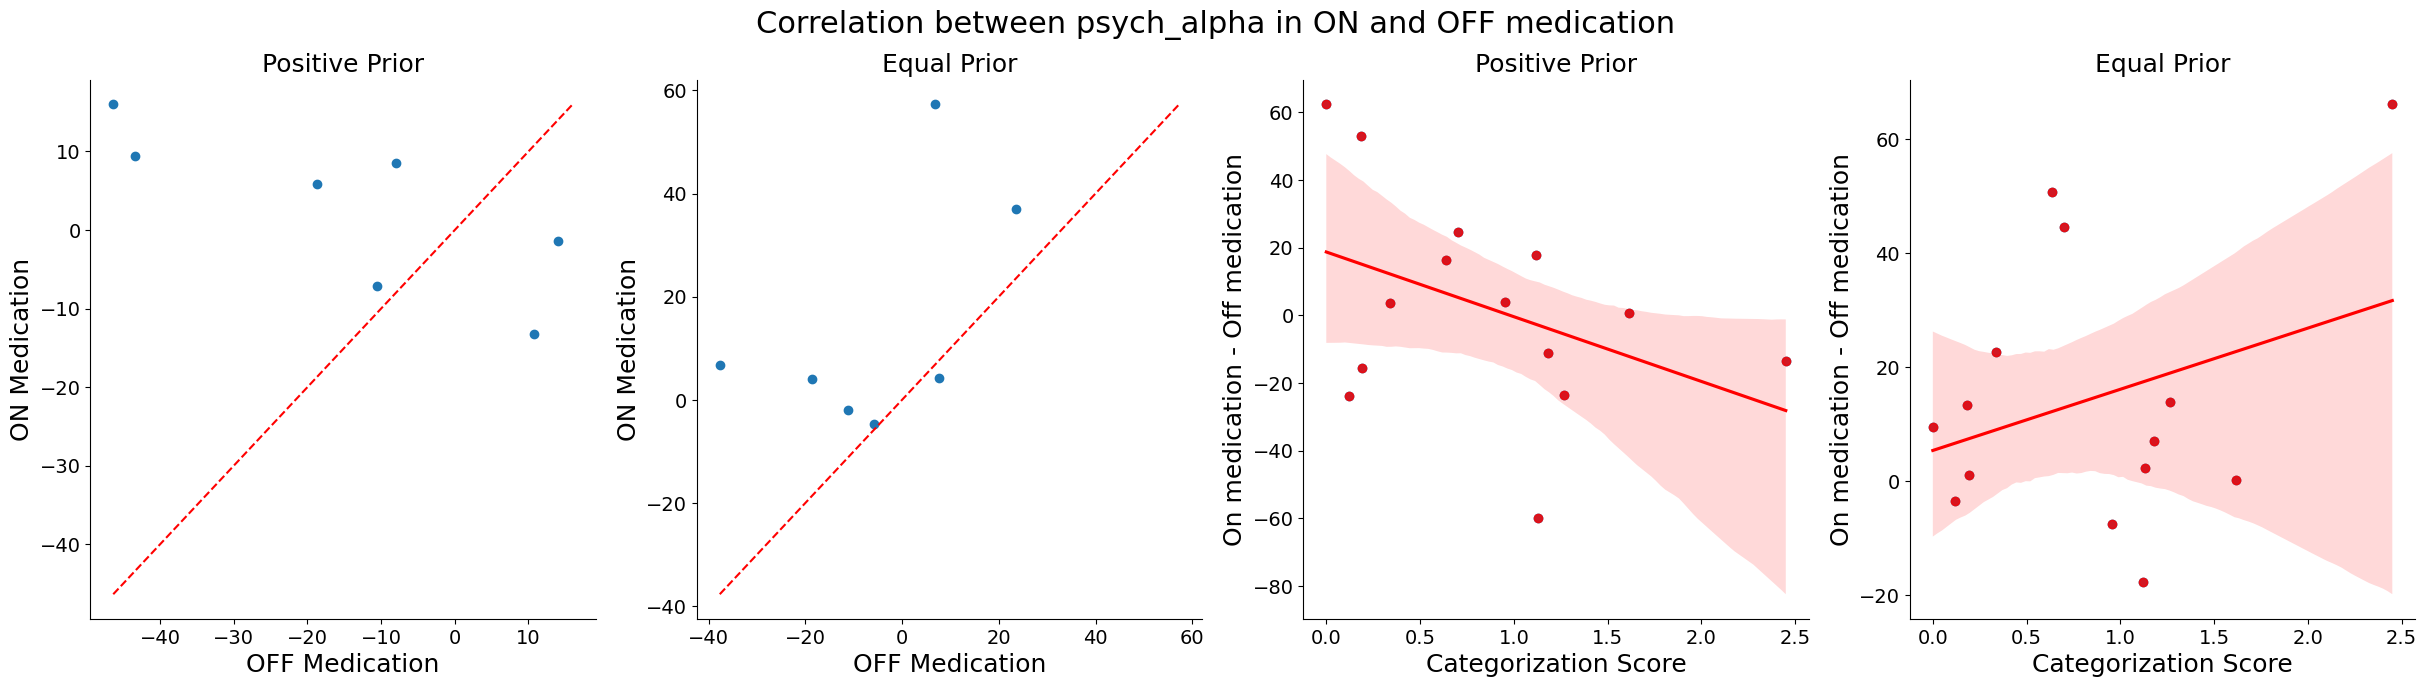

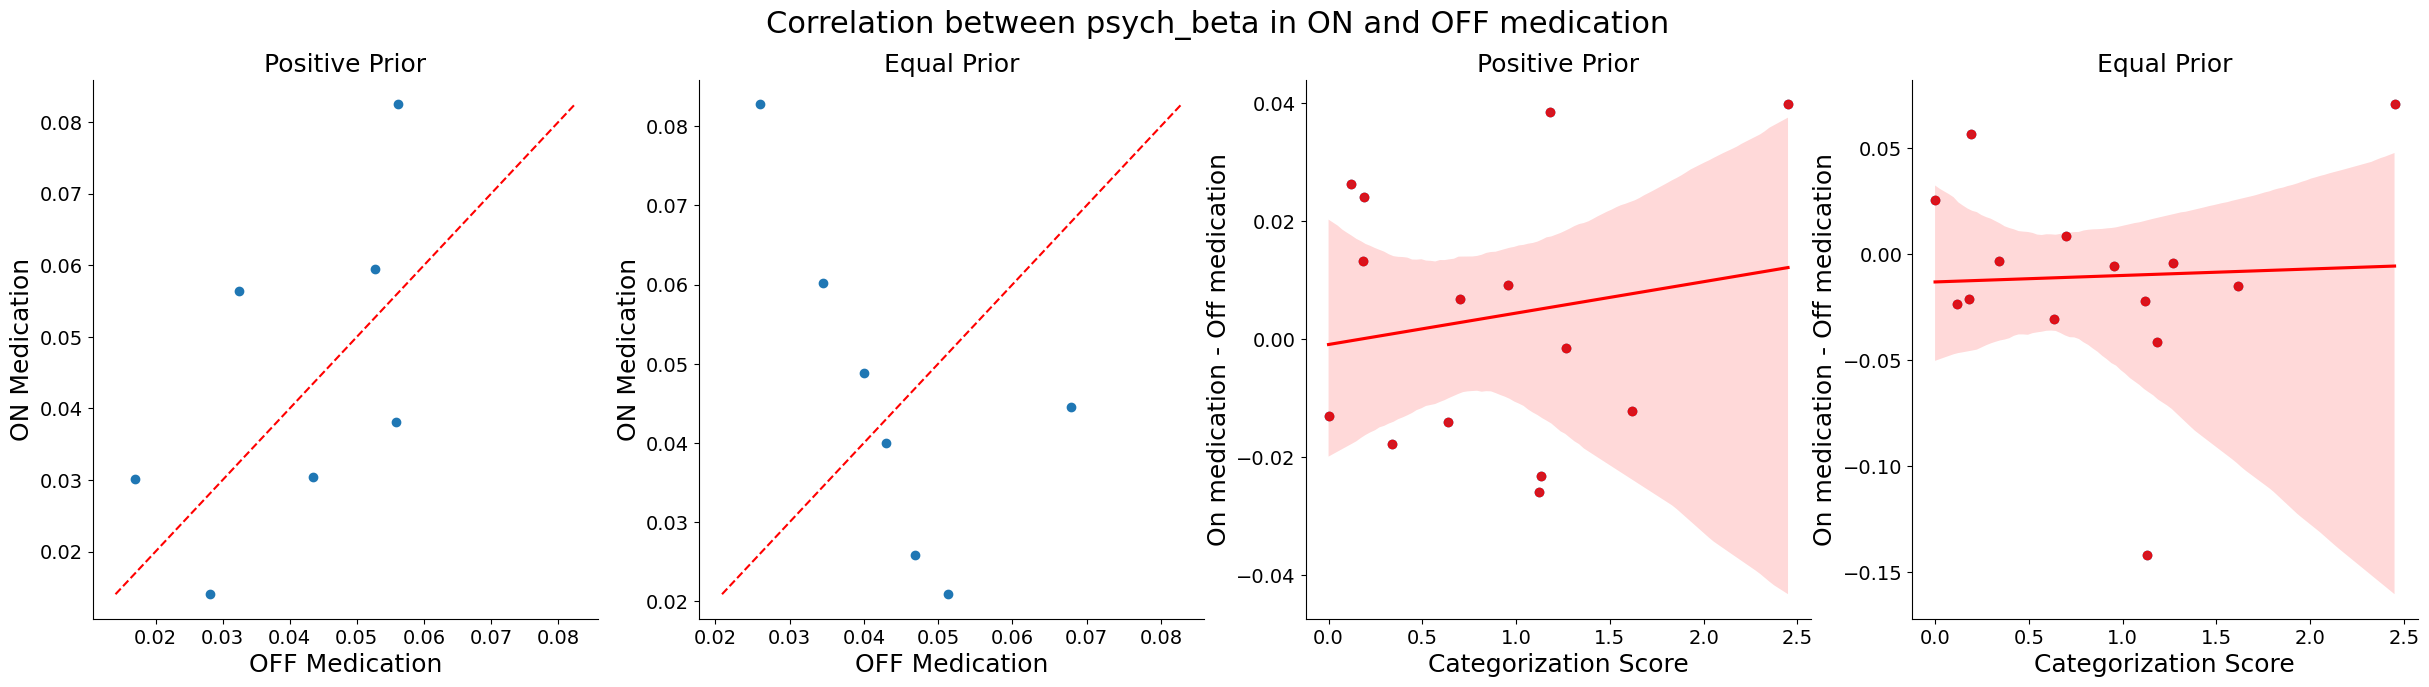

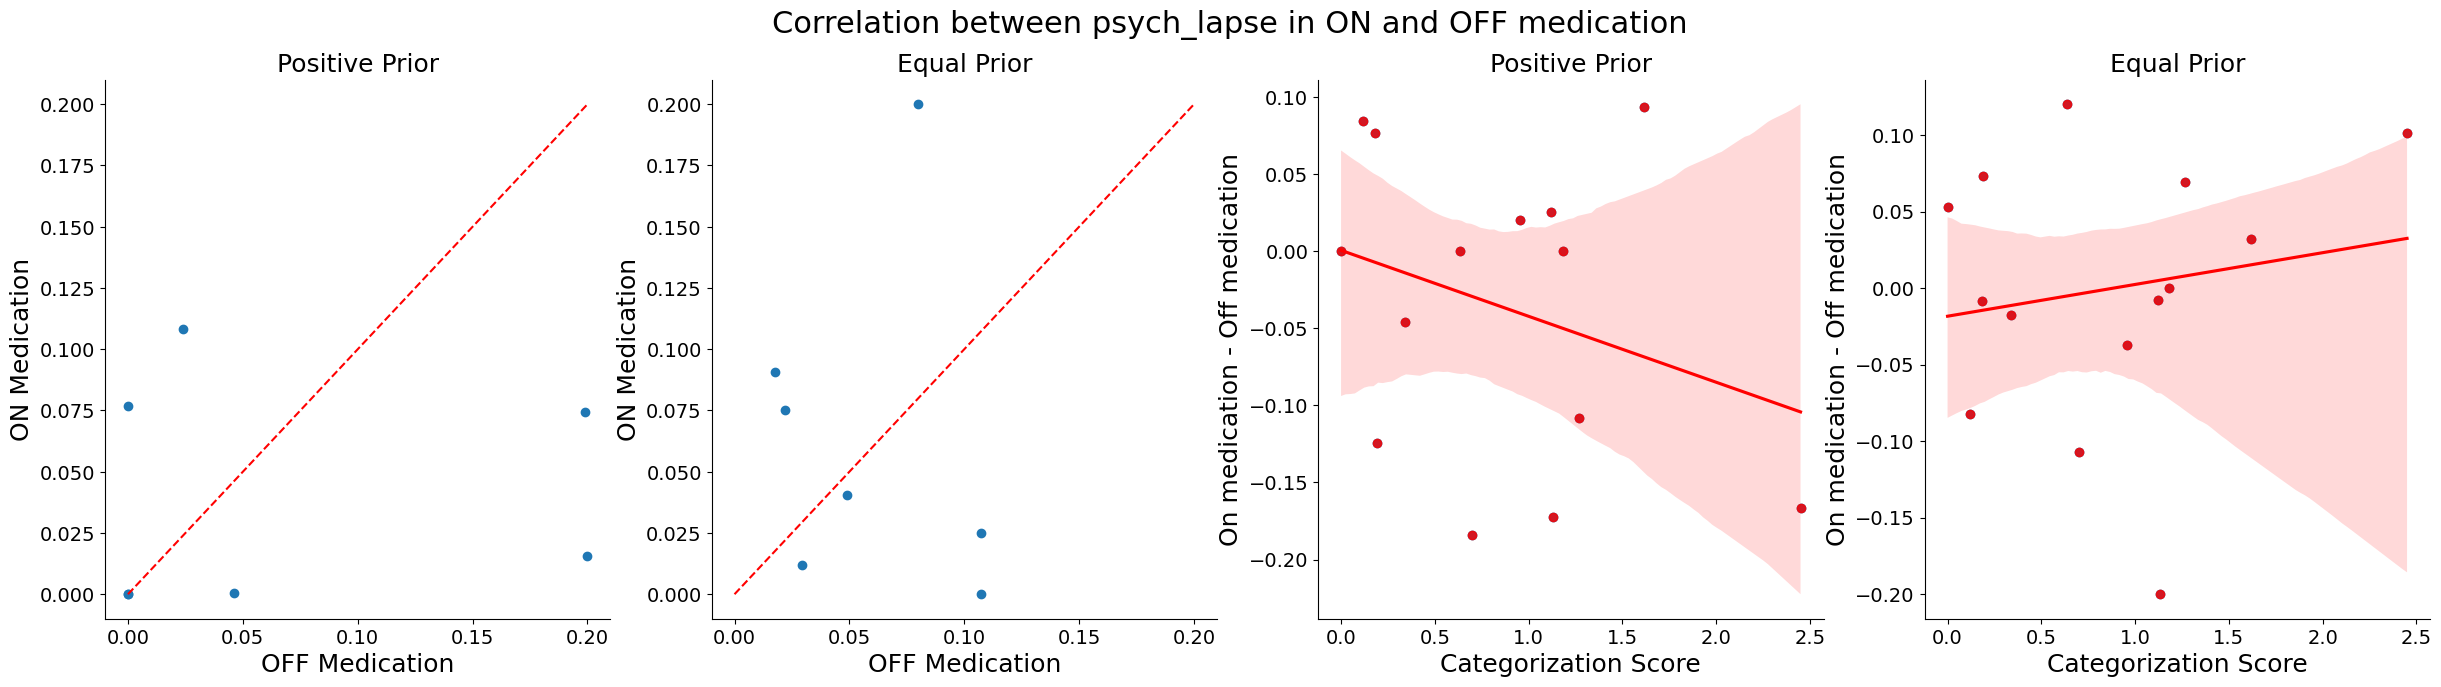

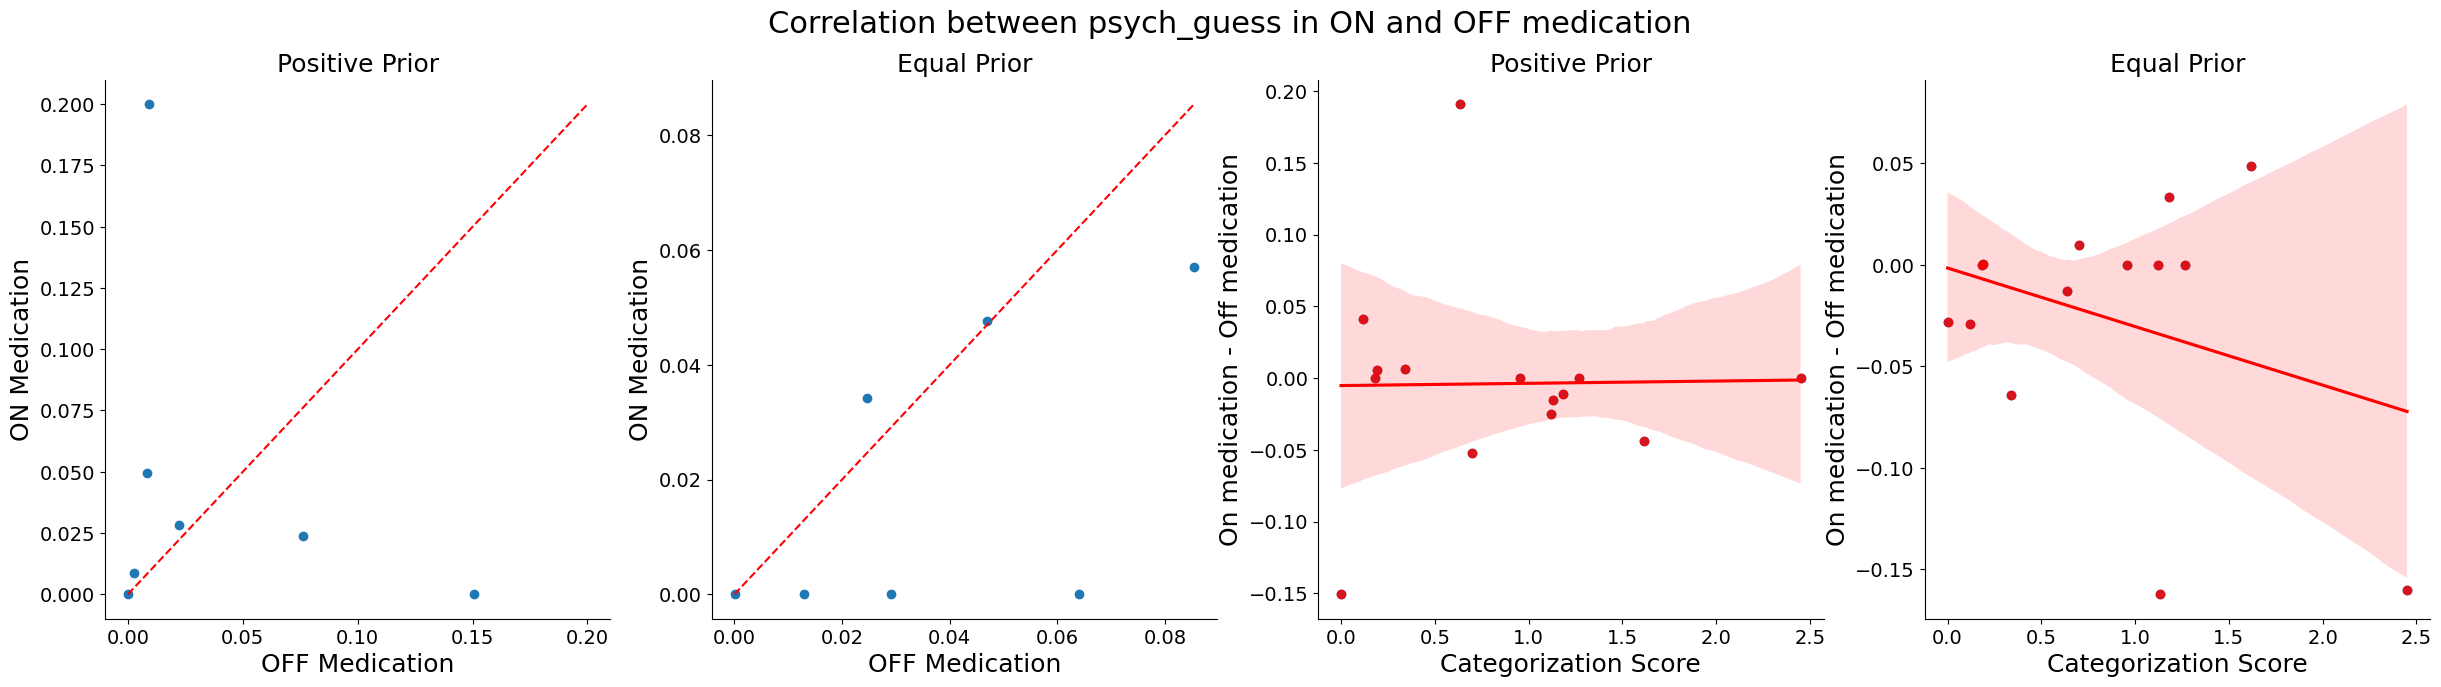

In [38]:
independent_variables = ['bias', 'psych_bias', 'psych_alpha', 'psych_beta', 'psych_lapse', 'psych_guess']

for independent_variable in independent_variables:

    fig, ax = plt.subplots(1, 4, figsize=(30, 7))
    ax[0].scatter(processed_metadata.loc[subject_treatment_idx['off']][f'positive_{independent_variable}'], processed_metadata.loc[subject_treatment_idx['on']][f'positive_{independent_variable}'])
    # get x_min, x_max, y_min, y_max
    x_min = min(processed_metadata.loc[subject_treatment_idx['off']][f'positive_{independent_variable}'].min(), processed_metadata.loc[subject_treatment_idx['on']][f'positive_{independent_variable}'].min())
    x_max = max(processed_metadata.loc[subject_treatment_idx['off']][f'positive_{independent_variable}'].max(), processed_metadata.loc[subject_treatment_idx['on']][f'positive_{independent_variable}'].max())
    y_min = min(processed_metadata.loc[subject_treatment_idx['off']][f'positive_{independent_variable}'].min(), processed_metadata.loc[subject_treatment_idx['on']][f'positive_{independent_variable}'].min())
    y_max = max(processed_metadata.loc[subject_treatment_idx['off']][f'positive_{independent_variable}'].max(), processed_metadata.loc[subject_treatment_idx['on']][f'positive_{independent_variable}'].max())
    ax[0].plot([x_min, x_max], [y_min, y_max], 'r--')
    ax[0].set_xlabel('OFF Medication', fontsize=18)
    ax[0].set_ylabel('ON Medication', fontsize=18)
    ax[0].set_title('Positive Prior', fontsize=18)    
    ax[0].tick_params(axis='both', labelsize=14)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)

    ax[1].scatter(processed_metadata.loc[subject_treatment_idx['off']][f'equal_{independent_variable}'], processed_metadata.loc[subject_treatment_idx['on']][f'equal_{independent_variable}'])
    # get x_min, x_max, y_min, y_max
    x_min = min(processed_metadata.loc[subject_treatment_idx['off']][f'equal_{independent_variable}'].min(), processed_metadata.loc[subject_treatment_idx['on']][f'equal_{independent_variable}'].min())
    x_max = max(processed_metadata.loc[subject_treatment_idx['off']][f'equal_{independent_variable}'].max(), processed_metadata.loc[subject_treatment_idx['on']][f'equal_{independent_variable}'].max())
    y_min = min(processed_metadata.loc[subject_treatment_idx['off']][f'equal_{independent_variable}'].min(), processed_metadata.loc[subject_treatment_idx['on']][f'equal_{independent_variable}'].min())
    y_max = max(processed_metadata.loc[subject_treatment_idx['off']][f'equal_{independent_variable}'].max(), processed_metadata.loc[subject_treatment_idx['on']][f'equal_{independent_variable}'].max())
    ax[1].plot([x_min, x_max], [y_min, y_max], 'r--')
    ax[1].set_xlabel('OFF Medication', fontsize=18)
    ax[1].set_ylabel('ON Medication', fontsize=18)
    ax[1].set_title('Equal Prior', fontsize=18)
    ax[1].tick_params(axis='both', labelsize=14)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    
    positive_diff = processed_metadata.loc[subtype_idx['on']][f'positive_{independent_variable}'].values - processed_metadata.loc[subtype_idx['off']][f'positive_{independent_variable}'].values
    ax[2].scatter(processed_metadata.loc[subtype_idx['off']]['categorization_score'], positive_diff)
    x_min = processed_metadata.loc[subtype_idx['off']]['categorization_score'].min()
    x_max = processed_metadata.loc[subtype_idx['off']]['categorization_score'].max()
    y_min = positive_diff.min()
    y_max = positive_diff.max()
    # plot regression line for the scatter plot
    sns.regplot(x=processed_metadata.loc[subtype_idx['off']]['categorization_score'], y=positive_diff, ax=ax[2], color='r')
    ax[2].set_xlabel('Categorization Score', fontsize=18)
    ax[2].set_ylabel('On medication - Off medication', fontsize=18)
    ax[2].set_title('Positive Prior', fontsize=18)    
    ax[2].tick_params(axis='both', labelsize=14)
    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    
    
    equal_diff = processed_metadata.loc[subtype_idx['on']][f'equal_{independent_variable}'].values - processed_metadata.loc[subtype_idx['off']][f'equal_{independent_variable}'].values
    ax[3].scatter(processed_metadata.loc[subtype_idx['off']]['categorization_score'], equal_diff)
    x_min = processed_metadata.loc[subtype_idx['off']]['categorization_score'].min()
    x_max = processed_metadata.loc[subtype_idx['off']]['categorization_score'].max()
    y_min = equal_diff.min()
    y_max = equal_diff.max()
    # plot regression line for the scatter plot
    sns.regplot(x=processed_metadata.loc[subtype_idx['off']]['categorization_score'], y=equal_diff, ax=ax[3], color='r')
    ax[3].set_xlabel('Categorization Score', fontsize=18)
    ax[3].set_ylabel('On medication - Off medication', fontsize=18)
    ax[3].set_title('Equal Prior', fontsize=18)    
    ax[3].tick_params(axis='both', labelsize=14)
    ax[3].spines['top'].set_visible(False)
    ax[3].spines['right'].set_visible(False)

    supertitle = f"Correlation between {independent_variable} in ON and OFF medication"
    fig.suptitle(supertitle, fontsize=22)

In [ ]:
off_positive_alpha = processed_metadata.loc[subtype_idx['off']][f'positive_psych_alpha'].values
off_equal_alpha = processed_metadata.loc[subtype_idx['off']][f'equal_psych_alpha'].values

# stats.ttest_rel(off_positive_alpha, off_equal_alpha)
stats.sem(off_positive_alpha), stats.sem(off_equal_alpha)
# type(off_positive_alpha)

print(f"Positive Psychometric Alpha: {np.mean(off_positive_alpha):.2f} +/- {stats.sem(off_positive_alpha):.2f}")
print(f"Equal Psychometric Alpha: {np.mean(off_equal_alpha):.2f} +/- {stats.sem(off_equal_alpha):.2f}")
# print with only 2 decimal points
print(f"t-statistic: {stats.ttest_rel(off_positive_alpha, off_equal_alpha)[0]:.3f}, p-value: {stats.ttest_rel(off_positive_alpha, off_equal_alpha)[1]:.3f}")



Positive Psychometric Alpha: -4.86 +/- 5.34
Equal Psychometric Alpha: -4.69 +/- 5.24
t-statistic: -0.020, p-value: 0.985


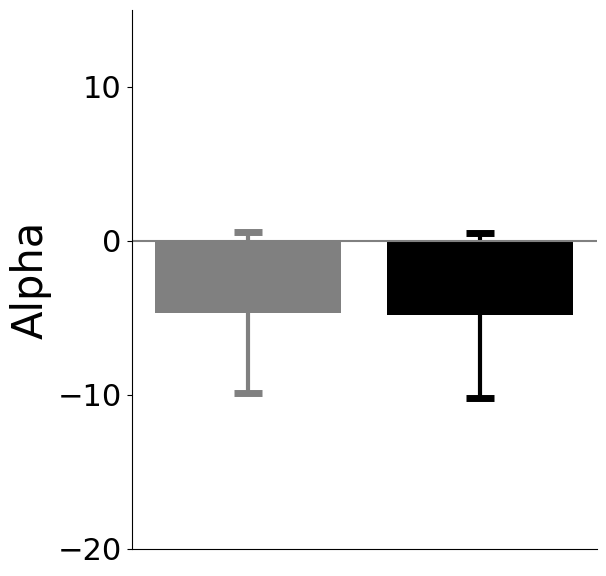

In [14]:
fig, ax = plt.subplots(1, figsize=(6, 7))
plt.bar([1], [np.mean(off_positive_alpha)], color=positive_color)
plt.bar([0], [np.mean(off_equal_alpha)], color=equal_color)
plt.errorbar([1], [np.mean(off_positive_alpha)], yerr=[stats.sem(off_positive_alpha)], color=positive_color, ls='', marker='', ms=12, mec='k', alpha=1, capsize=10, capthick=5, elinewidth=3, barsabove=True)
plt.errorbar([0], [np.mean(off_equal_alpha)], yerr=[stats.sem(off_equal_alpha)], color=equal_color, ls='', marker='', ms=12, mec='k', alpha=1, capsize=10, capthick=5, elinewidth=3, barsabove=True)
plt.hlines(0, -0.5, 1.5, color=[0.5, 0.5, 0.5], ls='-')
plt.xticks([])
plt.yticks([-20, -10, 0, 10, 20], fontsize=22)
plt.xlim(-0.5, 1.5)
plt.ylabel('Alpha', fontsize=30)
plt.ylim(-20, 15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.title('Psychometric Threshold', fontsize=25)
# plt.legend(fontsize=12)

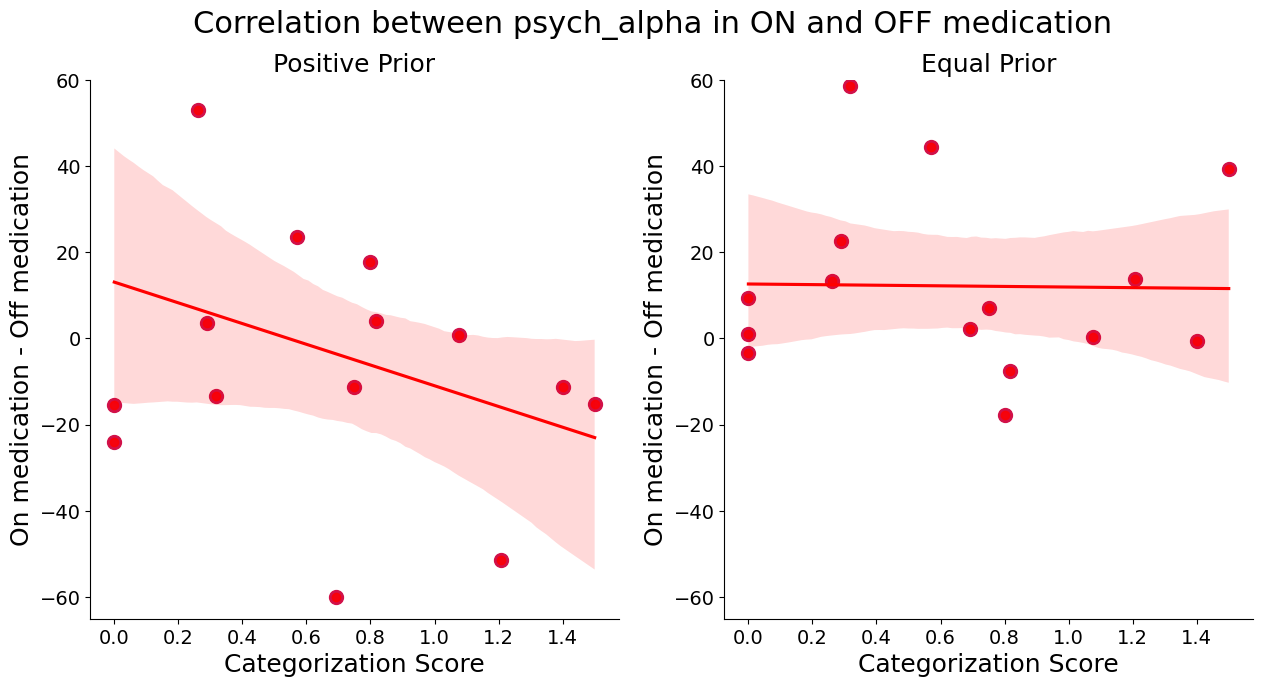

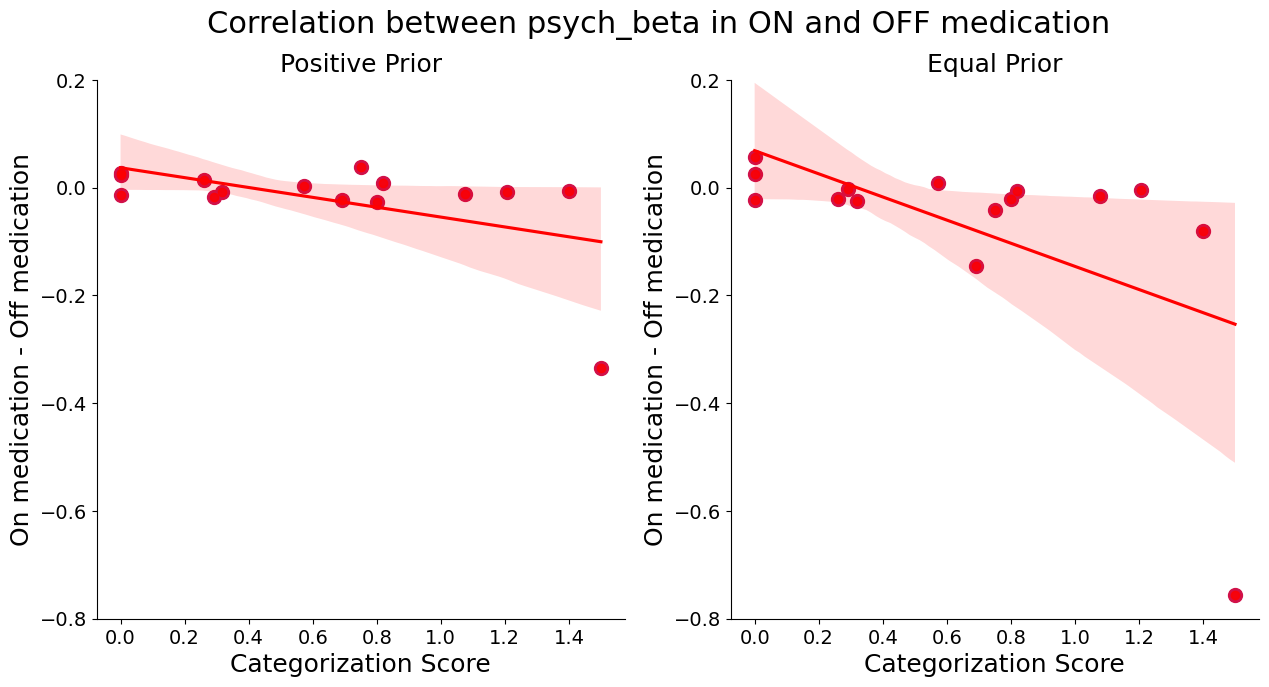

In [15]:

# independent_variables = ['bias', 'psych_bias', 'psych_alpha', 'psych_beta', 'psych_lapse', 'psych_guess']
independent_variables = ['psych_alpha', 'psych_beta']

for independent_variable in independent_variables:

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    positive_diff = processed_metadata.loc[subtype_idx['on']][f'positive_{independent_variable}'].values - processed_metadata.loc[subtype_idx['off']][f'positive_{independent_variable}'].values
    ax[0].scatter(processed_metadata.loc[subtype_idx['off']]['categorization_score'], positive_diff, s=100)
    x_min = processed_metadata.loc[subtype_idx['off']]['categorization_score'].min()
    x_max = processed_metadata.loc[subtype_idx['off']]['categorization_score'].max()
    y_min = positive_diff.min()
    y_max = positive_diff.max()
    # plot regression line for the scatter plot
    sns.regplot(x=processed_metadata.loc[subtype_idx['off']]['categorization_score'], y=positive_diff, ax=ax[0], color='r')
    ax[0].set_xlabel('Categorization Score', fontsize=18)
    ax[0].set_ylabel('On medication - Off medication', fontsize=18)
    ax[0].set_title('Positive Prior', fontsize=18)
    
    ax[0].tick_params(axis='both', labelsize=14)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    
    equal_diff = processed_metadata.loc[subtype_idx['on']][f'equal_{independent_variable}'].values - processed_metadata.loc[subtype_idx['off']][f'equal_{independent_variable}'].values
    ax[1].scatter(processed_metadata.loc[subtype_idx['off']]['categorization_score'], equal_diff, s=100)
    x_min = processed_metadata.loc[subtype_idx['off']]['categorization_score'].min()
    x_max = processed_metadata.loc[subtype_idx['off']]['categorization_score'].max()
    y_min = equal_diff.min()
    y_max = equal_diff.max()
    # plot regression line for the scatter plot
    sns.regplot(x=processed_metadata.loc[subtype_idx['off']]['categorization_score'], y=equal_diff, ax=ax[1], color='r')
    ax[1].set_xlabel('Categorization Score', fontsize=18)
    ax[1].set_ylabel('On medication - Off medication', fontsize=18)
    ax[1].set_title('Equal Prior', fontsize=18)
    
    ax[1].tick_params(axis='both', labelsize=14)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    
    if independent_variable == 'psych_alpha':
        ax[0].set_ylim(-65, 60)
        ax[1].set_ylim(-65, 60)
    elif independent_variable == 'psych_beta':
        ax[0].set_ylim(-0.8, 0.2)
        ax[1].set_ylim(-0.8, 0.2)
        

    supertitle = f"Correlation between {independent_variable} in ON and OFF medication"
    fig.suptitle(supertitle, fontsize=22)

### Statistical Testing

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     categorization_score   R-squared:                       0.012
Model:                              OLS   Adj. R-squared:                 -0.029
Method:                   Least Squares   F-statistic:                    0.2954
Date:                  Wed, 30 Oct 2024   Prob (F-statistic):              0.592
Time:                          19:50:02   Log-Likelihood:                -16.034
No. Observations:                    26   AIC:                             36.07
Df Residuals:                        24   BIC:                             38.58
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7300      0.247      2.951      0.007       0.220       1.240
UPDRS         -0.0066      0.012     -0.544      0.592      -0.032       0.019
==============================================================================
Omnibus:                        2.550   Durbin-Watson:                   0.964
Prob(Omnibus):                  0.279   Jarque-Bera (JB):                1.230
Skew:                          -0.029   Prob(JB):                        0.541
Kurtosis:                       1.936   Cond. No.                         55.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

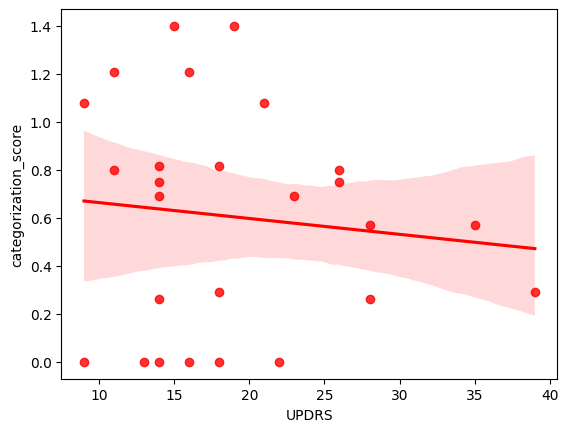

In [16]:
# Get indices where UPDRS score is not nan and categorization score is not nan
updrs_idx = processed_metadata.loc[~np.isnan(processed_metadata['UPDRS'])].index
categorization_idx = processed_metadata.loc[~np.isnan(processed_metadata['categorization_score'])].index
off_idx = processed_metadata.loc[processed_metadata['treatment'] == 'OFF'].index

common_idx = updrs_idx.intersection(categorization_idx)

sns.regplot(x=processed_metadata.loc[common_idx]['UPDRS'], y=processed_metadata.loc[common_idx]['categorization_score'], color='r')

sm.OLS(processed_metadata.loc[common_idx]['categorization_score'], sm.add_constant(processed_metadata.loc[common_idx]['UPDRS'])).fit().summary()

In [17]:
vars = ['positive_bias', 'positive_psych_bias', 'positive_psych_alpha', 'positive_psych_beta', 'positive_psych_lapse', 'positive_psych_guess', 
        'equal_bias', 'equal_psych_bias', 'equal_psych_alpha', 'equal_psych_beta', 'equal_psych_lapse', 'equal_psych_guess']

for var in vars:
    positive_diff = processed_metadata.loc[subtype_idx['on']][var].values - processed_metadata.loc[subtype_idx['off']][var].values
    pos_psych_model = sm.OLS(positive_diff, processed_metadata.loc[subtype_idx['off']]['categorization_score']).fit()
    pos_psych_model.summary()
    print(f"{var}: \t p-value: {pos_psych_model.pvalues[0].round(4)} \t R-squared: {pos_psych_model.rsquared.round(4)}")

positive_bias: 	 p-value: 0.9775 	 R-squared: 0.0001
positive_psych_bias: 	 p-value: 0.6134 	 R-squared: 0.0187
positive_psych_alpha: 	 p-value: 0.2943 	 R-squared: 0.0782
positive_psych_beta: 	 p-value: 0.0468 	 R-squared: 0.2534
positive_psych_lapse: 	 p-value: 0.0439 	 R-squared: 0.2594
positive_psych_guess: 	 p-value: 0.3187 	 R-squared: 0.0709
equal_bias: 	 p-value: 0.3749 	 R-squared: 0.0566
equal_psych_bias: 	 p-value: 0.3743 	 R-squared: 0.0567
equal_psych_alpha: 	 p-value: 0.1205 	 R-squared: 0.1634
equal_psych_beta: 	 p-value: 0.0165 	 R-squared: 0.3461
equal_psych_lapse: 	 p-value: 0.381 	 R-squared: 0.0552
equal_psych_guess: 	 p-value: 0.0817 	 R-squared: 0.2008
